In [1]:
# basics
import os
import time
import numpy as np
import pandas as pd

# scipy and sklearn
from scipy.stats import entropy
from sklearn.metrics import balanced_accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler

# plotting
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from matplotlib.collections import PatchCollection
import seaborn as sns
from IPython.display import Image
from matplotlib.patches import Rectangle

# CMDGB
import graphviz
from CMGDB import PlotMorseSets, PlotMorseGraph

# local
from data_loaders import retrieve_predictions
from models import *
from utils import get_model_weights, convert_weight_dict_to_dataframe, compute_morse_graph, \
                  compute_morse_graph_with_gpflow_gp, compute_order_retraction, PlotOrderRetraction

sns.set()
plt.style.use('ggplot')
%matplotlib inline
%load_ext autoreload
%autoreload 2

Using TensorFlow backend.


In [2]:
# suppress warnings
import warnings
warnings.filterwarnings('ignore')

In [3]:
# Pick interesting_iris from: ["iris_baseline", "iris_layers_2", "iris_epoch_450"]
interesting_iris = "iris_epoch_450"
# Pick smallest_or_largest from: ["smallest", "largest"]
smallest_or_largest = "largest"

Code:

[-2.61753082 -2.89198698]


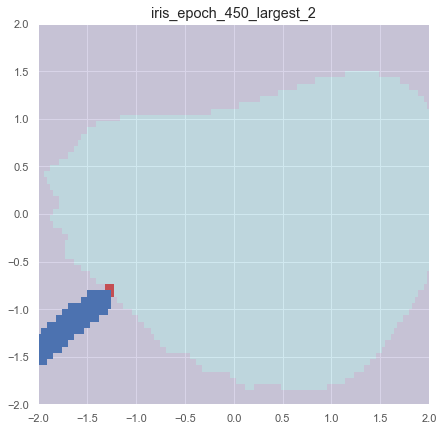

In [4]:
weights = get_model_weights("./data/{}".format(interesting_iris))
weights = convert_weight_dict_to_dataframe(weights)

final_weights = weights.loc[weights["epoch"] != "1"]    
weight_cols = [c for c in list(final_weights.columns) if c not in ["model_id", "epoch", "val_loss"]]
std_df = pd.DataFrame(columns=["weight_name", "std"],
                      data=list(zip(weight_cols, [np.std(final_weights[col]) for col in weight_cols])))
std_df = std_df.sort_values(by="std")

if smallest_or_largest == "smallest":
    two_weights = list(std_df["weight_name"])[:2]
elif smallest_or_largest == "largest":
    two_weights = list(std_df["weight_name"])[-2:]
else:
    raise ValueError()

morseg, mapg = compute_morse_graph(weights[['epoch'] + two_weights], phase_subdiv=15)

compute_order_retraction(morseg, mapg, title="{}_{}_2".format(interesting_iris, smallest_or_largest))

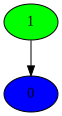

In [5]:
PlotMorseGraph(morseg)

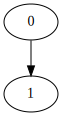

In [6]:
graphviz.Source.from_file('Hasse.dot')

In [7]:
# MUST BE SET MANUALLY FOR EACH RUN BASED ON ABOVE MORSE GRAPHS
morse_nodes_map = {1: 0, 0:1}

In [8]:
with open('CMGDB_retract.txt','r') as infile:
    retract_indices = []
    retract_tiles = []
    for i in range(mapg.num_vertices()): 
        index, tile = [int(x) for x in next(infile).split()]
        retract_indices.append(index)
        retract_tiles.append(tile)

In [9]:
weights_100 = get_model_weights("./data/iris_epoch_100")
weights_100 = convert_weight_dict_to_dataframe(weights_100)
weights_100 = weights_100[["model_id", "epoch", "val_loss"] + two_weights]

weights_150 = get_model_weights("./data/iris_baseline")
weights_150 = convert_weight_dict_to_dataframe(weights_150)
weights_150 = weights_150[["model_id", "epoch", "val_loss"] + two_weights]

weights_300 = get_model_weights("./data/iris_epoch_300")
weights_300 = convert_weight_dict_to_dataframe(weights_300)
weights_300 = weights_300[["model_id", "epoch", "val_loss"] + two_weights]

weights_450 = get_model_weights("./data/iris_epoch_450")
weights_450 = convert_weight_dict_to_dataframe(weights_450)
weights_450 = weights_450[["model_id", "epoch", "val_loss"] + two_weights]

In [10]:
print(two_weights[0])
print("min", weights_450[two_weights[0]].min() - 0.5)
print("max", weights_450[two_weights[0]].max() + 0.5)
print()
print(two_weights[1])
print("min", weights_450[two_weights[1]].min() - 0.5)
print("max", weights_450[two_weights[1]].max() + 0.5)

dense_kernel_0_3
min -5.510294437408447
max 2.4659719467163086

dense_kernel_0_0
min -5.970724582672119
max 2.45885169506073


In [11]:
# PlotOrderRetraction(morseg, mapg, retract_tiles, retract_indices, morse_nodes_map, 
#                     df_of_interest=weights_100, x=two_weights[0], y=two_weights[1], hue="epoch")

In [12]:
# PlotOrderRetraction(morseg, mapg, retract_tiles, retract_indices, morse_nodes_map, 
#                     df_of_interest=weights_150, x=two_weights[0], y=two_weights[1], hue="epoch")

In [13]:
# PlotOrderRetraction(morseg, mapg, retract_tiles, retract_indices, morse_nodes_map, 
#                     df_of_interest=weights_300, x=two_weights[0], y=two_weights[1], hue="epoch")

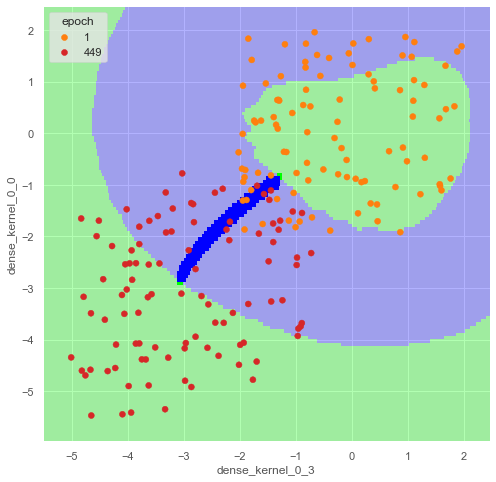

In [14]:
PlotOrderRetraction(morseg, mapg, retract_tiles, retract_indices, morse_nodes_map, 
                    df_of_interest=weights_450, x=two_weights[0], y=two_weights[1], hue="epoch")

In [15]:
inside_outside_df = weights_450.copy()
inside_outside_df = inside_outside_df.loc[inside_outside_df["epoch"] == "1"]
inside_outside_df = inside_outside_df.drop(columns="epoch")
inside_outside_df["inside_outside"] = "inside"
inside_outside_df["inside_outside"][0] = "outside"
inside_outside_df.loc[inside_outside_df["dense_kernel_0_0"] > 1.4, "inside_outside"] = "outside"
inside_outside_df.loc[(inside_outside_df["dense_kernel_0_0"] > 0.9) & (inside_outside_df["dense_kernel_0_3"] < 0.1), 
                      "inside_outside"] = "outside"
inside_outside_df.loc[inside_outside_df["dense_kernel_0_3"] < -1.75, "inside_outside"] = "outside"
inside_outside_df.loc[(inside_outside_df["dense_kernel_0_0"] < -0.75) & (inside_outside_df["dense_kernel_0_3"] < -1), 
                      "inside_outside"] = "outside"
inside_outside_df.loc[(inside_outside_df["dense_kernel_0_0"] < -1.5) & (inside_outside_df["dense_kernel_0_3"] < -0.5), 
                      "inside_outside"] = "outside"
inside_outside_df.loc[inside_outside_df["dense_kernel_0_0"] < -1.8, "inside_outside"] = "outside"

In [16]:
inside_outside_df

,model_id,val_loss,dense_kernel_0_3,dense_kernel_0_0,inside_outside
model.49-1-2.90.hdf5,model.49,2.90,-0.827550,1.383623,outside
model.28-1-1.47.hdf5,model.28,1.47,-0.864604,0.547236,inside
model.13-1-2.61.hdf5,model.13,2.61,1.074189,1.482288,outside
model.84-1-1.82.hdf5,model.84,1.82,1.308823,-0.475314,inside
model.45-1-0.59.hdf5,model.45,0.59,-0.504291,-0.701395,inside
...,...,...,...,...,...
model.2-1-1.94.hdf5,model.2,1.94,0.989762,-0.542829,inside
model.3-1-1.33.hdf5,model.3,1.33,-1.911916,-0.852151,outside
model.35-1-2.67.hdf5,model.35,2.67,-0.558142,1.111496,outside
model.74-1-1.46.hdf5,model.74,1.46,-0.660994,1.958852,outside


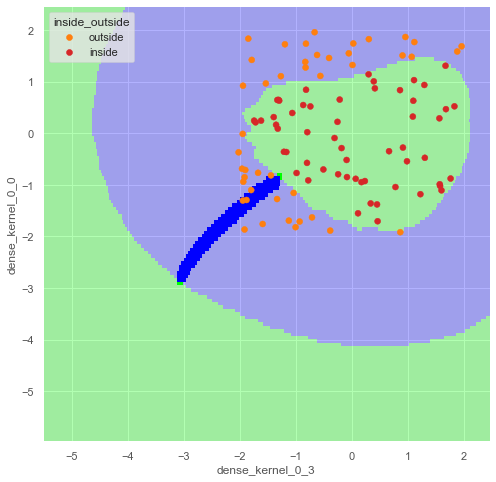

In [17]:
PlotOrderRetraction(morseg, mapg, retract_tiles, retract_indices, morse_nodes_map, 
                    df_of_interest=inside_outside_df, x=two_weights[0], y=two_weights[1], hue="inside_outside")

In [18]:
inside_outside_df

,model_id,val_loss,dense_kernel_0_3,dense_kernel_0_0,inside_outside
model.49-1-2.90.hdf5,model.49,2.90,-0.827550,1.383623,outside
model.28-1-1.47.hdf5,model.28,1.47,-0.864604,0.547236,inside
model.13-1-2.61.hdf5,model.13,2.61,1.074189,1.482288,outside
model.84-1-1.82.hdf5,model.84,1.82,1.308823,-0.475314,inside
model.45-1-0.59.hdf5,model.45,0.59,-0.504291,-0.701395,inside
...,...,...,...,...,...
model.2-1-1.94.hdf5,model.2,1.94,0.989762,-0.542829,inside
model.3-1-1.33.hdf5,model.3,1.33,-1.911916,-0.852151,outside
model.35-1-2.67.hdf5,model.35,2.67,-0.558142,1.111496,outside
model.74-1-1.46.hdf5,model.74,1.46,-0.660994,1.958852,outside
